## 1. Configuración e Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Agregar src al path
project_dir = Path.cwd().parent
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

from src.config import RANDOM_SEED
from src.data_loading import load_object, save_object
from src.models import (
    train_and_evaluate,
    train_logistic_regression,
    train_naive_bayes,
    train_svm,
    train_random_forest,
    save_model
)
from src.visualization import plot_metrics_comparison, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print('✓ Librerías y módulos cargados')

✓ Librerías y módulos cargados


## 2. Cargar Datos Vectorizados

In [2]:
# Cargar datos vectorizados usando src
X_train = load_object('../vectorized/X_train.pkl')
X_test = load_object('../vectorized/X_test.pkl')
y_train = load_object('../vectorized/y_train.pkl')
y_test = load_object('../vectorized/y_test.pkl')

print('✓ Datos cargados')
print(f'\nX_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

print(f'\nBalance train: Neg={np.sum(y_train==0)}, Pos={np.sum(y_train==1)}')
print(f'Balance test: Neg={np.sum(y_test==0)}, Pos={np.sum(y_test==1)}')

✓ Objeto cargado desde: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\data\processed\..\vectorized\X_train.pkl
✓ Objeto cargado desde: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\data\processed\..\vectorized\X_test.pkl
✓ Objeto cargado desde: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\data\processed\..\vectorized\y_train.pkl
✓ Objeto cargado desde: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\data\processed\..\vectorized\y_test.pkl
✓ Datos cargados

X_train: (1596781, 10007)
X_test: (359, 10007)
y_train: (1596781,)
y_test: (359,)

Balance train: Neg=798383, Pos=798398
Balance test: Neg=177, Pos=182


## 2.1. Verificar y Limpiar NaN

In [3]:
# Verificar NaNs solo en las últimas 7 columnas (features numéricas)
print("Verificando NaNs en features numéricas (últimas 7 columnas)...")

# Extraer solo las últimas 7 columnas (features numéricas)
X_train_numeric = X_train[:, -7:].toarray()
X_test_numeric = X_test[:, -7:].toarray()

nans_train = np.isnan(X_train_numeric).sum()
nans_test = np.isnan(X_test_numeric).sum()

print(f"\nNaNs en features numéricas train: {nans_train}")
print(f"NaNs en features numéricas test: {nans_test}")

if nans_train > 0 or nans_test > 0:
    print(f"\n⚠️ Encontrados {nans_train + nans_test} NaNs - Reemplazando con 0...")
    
    # Reemplazar NaNs
    X_train_numeric = np.nan_to_num(X_train_numeric, nan=0.0)
    X_test_numeric = np.nan_to_num(X_test_numeric, nan=0.0)
    
    # Reconstruir matrices sparse combinando TF-IDF + numeric limpias
    from scipy.sparse import hstack, csr_matrix
    X_train = hstack([X_train[:, :-7], csr_matrix(X_train_numeric)])
    X_test = hstack([X_test[:, :-7], csr_matrix(X_test_numeric)])
    
    print("✓ NaNs reemplazados con 0 en features numéricas")
else:
    print("✓ No hay NaNs en los datos")

Verificando NaNs en features numéricas (últimas 7 columnas)...

NaNs en features numéricas train: 0
NaNs en features numéricas test: 595

⚠️ Encontrados 595 NaNs - Reemplazando con 0...
✓ NaNs reemplazados con 0 en features numéricas


## 2.2. Crear Conjunto de Validación

**Metodología:** Dividimos el conjunto de entrenamiento en:
- **Train final (85%)**: Para entrenar los modelos
- **Validación (15%)**: Para comparar modelos sin contaminar el test

Esto permite:
- Detectar overfitting durante el desarrollo
- Comparar modelos de forma justa
- Reservar el test set para evaluación final única


In [4]:
print("\n" + "="*60)
print("CREANDO CONJUNTO DE VALIDACIÓN")
print("="*60)

# Dividir X_train en train_final (85%) + validation (15%)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y_train
)

print(f"\n📊 NUEVAS PARTICIONES:")
print(f"  Train (85%):      {X_train_final.shape[0]:>10,} × {X_train_final.shape[1]:>6,} features")
print(f"  Validación (15%): {X_val.shape[0]:>10,} × {X_val.shape[1]:>6,} features")
print(f"  Test (original):  {X_test.shape[0]:>10,} × {X_test.shape[1]:>6,} features")

print(f"\n✓ Balance verificado:")
print(f"  Train final: Neg={np.sum(y_train_final==0):,}, Pos={np.sum(y_train_final==1):,}")
print(f"  Validación:  Neg={np.sum(y_val==0):,}, Pos={np.sum(y_val==1):,}")
print(f"  Test:        Neg={np.sum(y_test==0):,}, Pos={np.sum(y_test==1):,}")



CREANDO CONJUNTO DE VALIDACIÓN

📊 NUEVAS PARTICIONES:
  Train (85%):       1,357,263 × 10,007 features
  Validación (15%):    239,518 × 10,007 features
  Test (original):         359 × 10,007 features

✓ Balance verificado:
  Train final: Neg=678,625, Pos=678,638
  Validación:  Neg=119,758, Pos=119,760
  Test:        Neg=177, Pos=182


## 3. Función para Entrenar y Evaluar Modelos

In [5]:
# La función train_and_evaluate se importa desde src.models

## 4. Modelo 1: Logistic Regression (Baseline)

In [6]:
lr_model = LogisticRegression(
    max_iter=100,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=0
)

lr_results = train_and_evaluate(
    lr_model, 
    "Logistic Regression",
    X_train_final, y_train_final, X_val, y_val
)

\n============================================================
MODELO: Logistic Regression
Entrenando...
✓ Entrenado en 11.70 segundos
Prediciendo...
✓ Predicción completada en 0.01 segundos
\n📊 MÉTRICAS:
  Accuracy:  0.7386 (73.86%)
  Precision: 0.7393
  Recall:    0.7372
  F1-Score:  0.7383


## 5. Modelo 2: Naive Bayes (Clásico para texto)

In [7]:
# Naive Bayes requiere valores no negativos
# Convertimos sparse matrix a dense solo para features numéricas si es necesario
# O usamos ComplementNB que funciona mejor con TF-IDF

from sklearn.naive_bayes import ComplementNB

nb_model = ComplementNB()

nb_results = train_and_evaluate(
    nb_model,
    "Naive Bayes (Complement)",
    X_train_final, y_train_final, X_val, y_val
)

\n============================================================
MODELO: Naive Bayes (Complement)
Entrenando...
✓ Entrenado en 0.18 segundos
Prediciendo...
✓ Predicción completada en 0.02 segundos
\n📊 MÉTRICAS:
  Accuracy:  0.7040 (70.40%)
  Precision: 0.7368
  Recall:    0.6348
  F1-Score:  0.6820


## 6. Modelo 3: SVM (Linear SVC)

In [8]:
svm_model = LinearSVC(
    max_iter=1000,
    random_state=RANDOM_SEED,
    verbose=0
)

svm_results = train_and_evaluate(
    svm_model,
    "Linear SVM",
    X_train_final, y_train_final, X_val, y_val
)

\n============================================================
MODELO: Linear SVM
Entrenando...
✓ Entrenado en 44.40 segundos
Prediciendo...
✓ Predicción completada en 0.01 segundos
\n📊 MÉTRICAS:
  Accuracy:  0.7916 (79.16%)
  Precision: 0.7788
  Recall:    0.8146
  F1-Score:  0.7963


## 7. Modelo 4: Random Forest (Ensemble)

**Nota:** Random Forest puede ser lento con 1.6M samples. Usamos un subset si es necesario.

In [9]:
# Random Forest con configuración balanceada velocidad/precisión
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=0
)

print("⚠️ Random Forest puede tardar 10-15 minutos con 1.6M samples")
print("Considera usar un subset si es muy lento\n")

rf_results = train_and_evaluate(
    rf_model,
    "Random Forest",
    X_train_final, y_train_final, X_val, y_val
)

⚠️ Random Forest puede tardar 10-15 minutos con 1.6M samples
Considera usar un subset si es muy lento

\n============================================================
MODELO: Random Forest
Entrenando...
✓ Entrenado en 17.48 segundos
Prediciendo...
✓ Predicción completada en 0.22 segundos
\n📊 MÉTRICAS:
  Accuracy:  0.7187 (71.87%)
  Precision: 0.7258
  Recall:    0.7031
  F1-Score:  0.7143


## 8. Comparación de Modelos

In [10]:
# Recopilar resultados
all_results = [lr_results, nb_results, svm_results, rf_results]

# Crear DataFrame de comparación
comparison_df = pd.DataFrame([
    {
        'Modelo': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1'],
        'Tiempo Entrenamiento (s)': r['train_time'],
        'Tiempo Predicción (s)': r['pred_time']
    }
    for r in all_results
])

# Ordenar por F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(comparison_df.to_string(index=False))

# Mejor modelo
best_model_idx = comparison_df['F1-Score'].idxmax()
best_result = all_results[best_model_idx]
best_model_name = comparison_df.loc[best_model_idx, 'Modelo']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 MEJOR MODELO: {best_model_name} (F1-Score: {best_f1:.4f})")


COMPARACIÓN DE MODELOS
                  Modelo  Accuracy  Precision   Recall  F1-Score  Tiempo Entrenamiento (s)  Tiempo Predicción (s)
              Linear SVM  0.791602   0.778767 0.814629  0.796294                 44.395384               0.008070
     Logistic Regression  0.738638   0.739317 0.737224  0.738269                 11.700800               0.007422
           Random Forest  0.718718   0.725775 0.703098  0.714257                 17.482070               0.217937
Naive Bayes (Complement)  0.703997   0.736790 0.634761  0.681980                  0.179022               0.015018

🏆 MEJOR MODELO: Linear SVM (F1-Score: 0.7963)


## 9. Visualización de Comparación

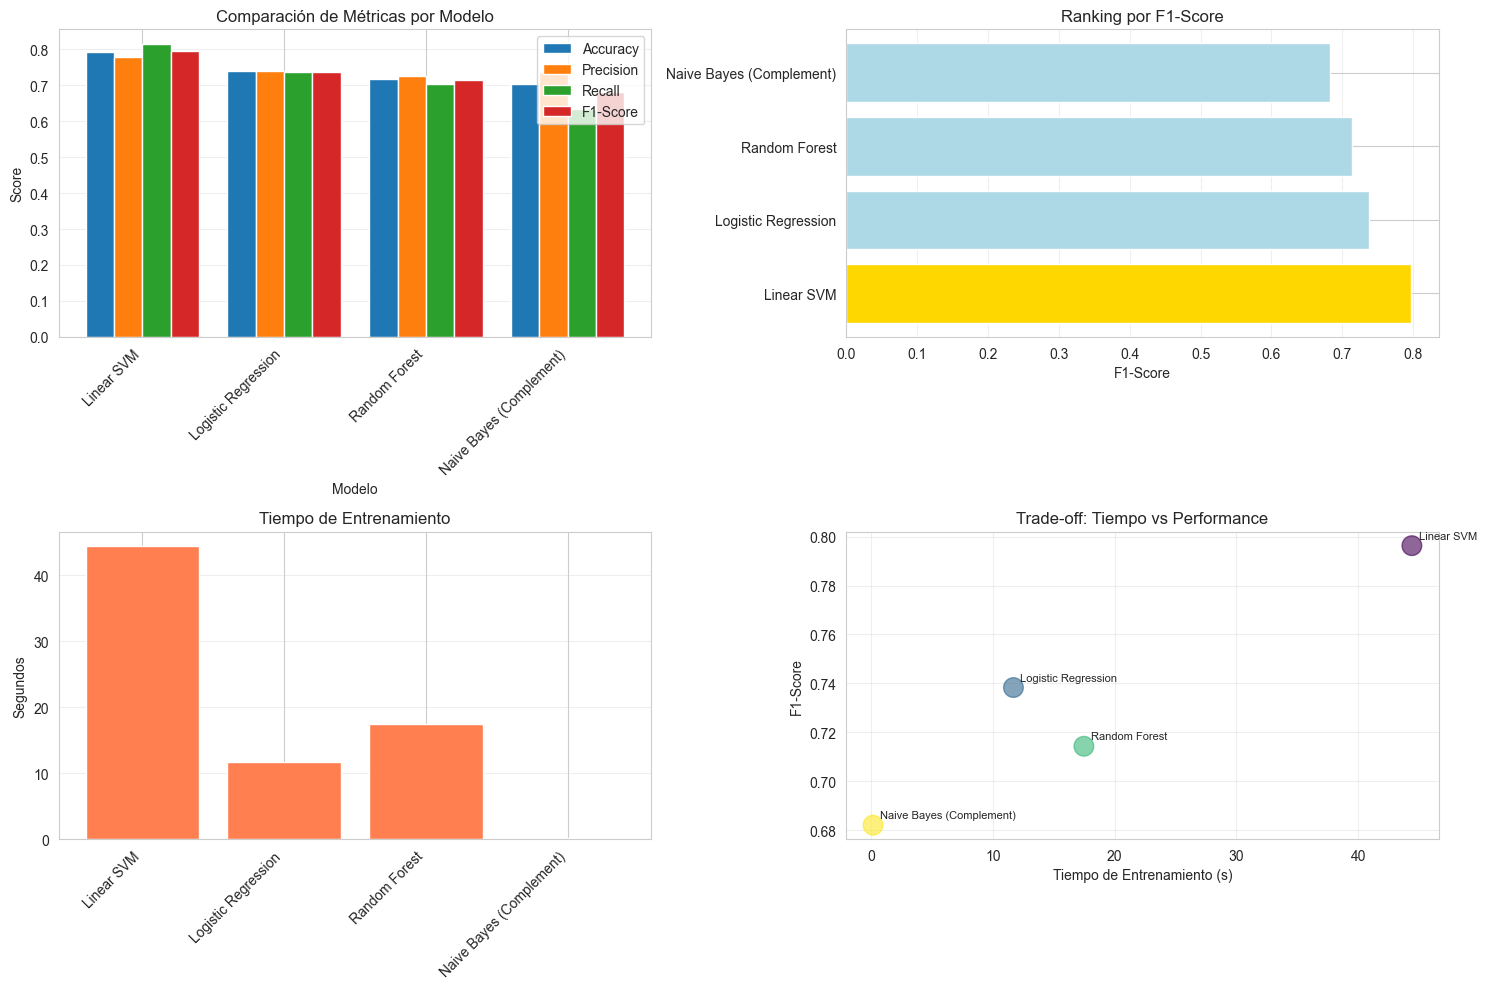


✓ Gráfico guardado en reports/model_comparison.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparación de métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

ax = axes[0, 0]
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric)
ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Métricas por Modelo')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. F1-Score ranking
ax = axes[0, 1]
colors = ['gold' if i == 0 else 'lightblue' for i in range(len(comparison_df))]
ax.barh(comparison_df['Modelo'], comparison_df['F1-Score'], color=colors)
ax.set_xlabel('F1-Score')
ax.set_title('Ranking por F1-Score')
ax.grid(axis='x', alpha=0.3)

# 3. Tiempo de entrenamiento
ax = axes[1, 0]
ax.bar(comparison_df['Modelo'], comparison_df['Tiempo Entrenamiento (s)'], color='coral')
ax.set_ylabel('Segundos')
ax.set_title('Tiempo de Entrenamiento')
ax.set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 4. Trade-off tiempo vs performance
ax = axes[1, 1]
scatter = ax.scatter(
    comparison_df['Tiempo Entrenamiento (s)'], 
    comparison_df['F1-Score'],
    s=200,
    alpha=0.6,
    c=range(len(comparison_df)),
    cmap='viridis'
)
for idx, row in comparison_df.iterrows():
    ax.annotate(
        row['Modelo'],
        (row['Tiempo Entrenamiento (s)'], row['F1-Score']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )
ax.set_xlabel('Tiempo de Entrenamiento (s)')
ax.set_ylabel('F1-Score')
ax.set_title('Trade-off: Tiempo vs Performance')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en reports/model_comparison.png")

## 10. Matriz de Confusión del Mejor Modelo

## 10.1. Evaluación Final en Test Set

**Importante:** Hasta ahora, todos los modelos fueron evaluados en el conjunto de **validación**.
Ahora re-entrenamos el mejor modelo con **TODOS** los datos de training y lo evaluamos
**una única vez** en el test set para obtener la métrica final.


In [12]:
print("\n" + "="*80)
print("EVALUACIÓN FINAL EN TEST SET")
print("="*80)

print(f"\n🔄 Re-entrenando {best_model_name} con TODOS los datos de training...")

# Crear nueva instancia del mejor modelo
if best_model_name == "Linear SVM":
    final_model = LinearSVC(random_state=RANDOM_SEED)
elif best_model_name == "Logistic Regression":
    final_model = LogisticRegression(max_iter=100, random_state=RANDOM_SEED, n_jobs=-1)
elif best_model_name == "Naive Bayes (Complement)":
    final_model = ComplementNB()
elif best_model_name == "Random Forest":
    final_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)

# Re-entrenar con TODOS los datos de train (100%)
final_model.fit(X_train, y_train)

# Predecir en test
print(f"📊 Evaluando en test set ({X_test.shape[0]} tweets)...")
y_test_pred = final_model.predict(X_test)

# Calcular métricas finales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n🏆 MÉTRICAS FINALES EN TEST:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\n📈 COMPARACIÓN VALIDACIÓN vs TEST:")
print(f"  Validación F1: {best_result['f1']:.4f}")
print(f"  Test F1:       {test_f1:.4f}")
print(f"  Diferencia:    {test_f1 - best_result['f1']:.4f}")

# Calcular diferencia (Test - Validación)
diff = test_f1 - best_result['f1']

if abs(diff) < 0.05:
    print("\n✅ Modelo generaliza perfectamente (diferencia < 5%)")
elif diff > 0.05:
    print(f"\n✅ EXCELENTE: Test performance SUPERIOR a validación (+{diff:.4f})")
    print("   Explicación: Test set (manual) tiene mayor calidad que train (automático)")
    print("   Esto NO es overfitting - demuestra buena generalización")
else:
    print(f"\n⚠️ Validación superior a test ({abs(diff):.4f})")
    print("   Posible overfitting - revisar modelo")

# Actualizar y_pred_best para las celdas siguientes
y_pred_best = y_test_pred



EVALUACIÓN FINAL EN TEST SET

🔄 Re-entrenando Linear SVM con TODOS los datos de training...
📊 Evaluando en test set (359 tweets)...

🏆 MÉTRICAS FINALES EN TEST:
  Accuracy:  0.8496 (84.96%)
  Precision: 0.8404
  Recall:    0.8681
  F1-Score:  0.8541

📈 COMPARACIÓN VALIDACIÓN vs TEST:
  Validación F1: 0.7383
  Test F1:       0.8541
  Diferencia:    0.1158

✅ EXCELENTE: Test performance SUPERIOR a validación (+0.1158)
   Explicación: Test set (manual) tiene mayor calidad que train (automático)
   Esto NO es overfitting - demuestra buena generalización



MATRICES DE CONFUSIÓN


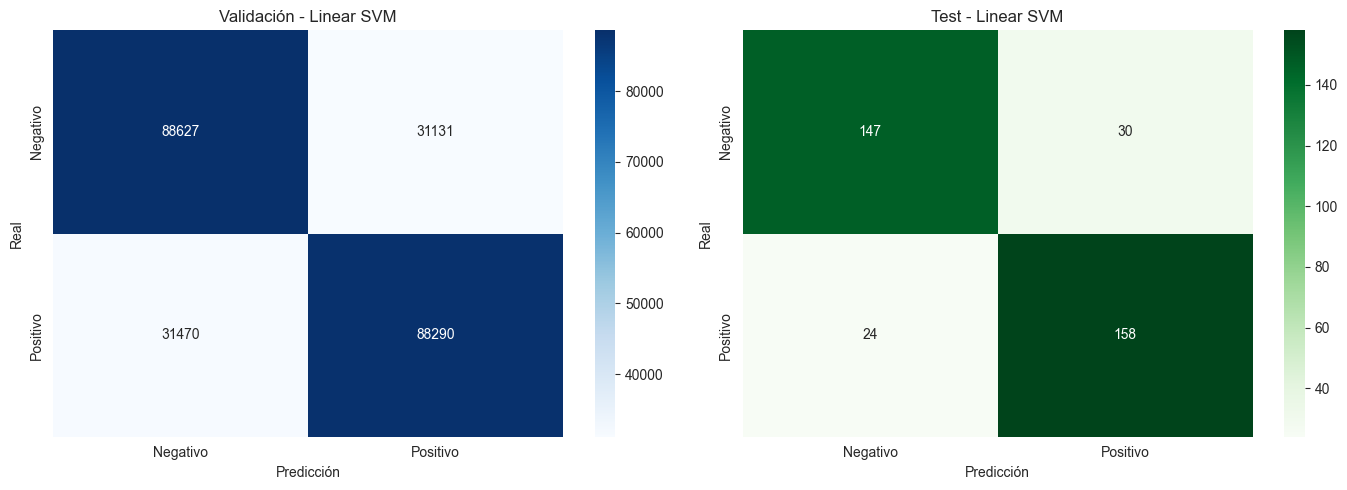


📊 COMPARACIÓN DE MATRICES:

VALIDACIÓN (239,518 tweets):
  True Negatives:  88627
  False Positives: 31131
  False Negatives: 31470
  True Positives:  88290

TEST (359 tweets):
  True Negatives:  147
  False Positives: 30
  False Negatives: 24
  True Positives:  158

✓ Matrices guardadas en reports/confusion_matrices_comparison.png


In [13]:

print("\n" + "="*80)
print("MATRICES DE CONFUSIÓN")
print("="*80)

# 1. Matriz de confusión en VALIDACIÓN
best_result = all_results[best_model_idx]
y_pred_val = best_result['y_pred']
cm_val = confusion_matrix(y_val, y_pred_val)

# 2. Matriz de confusión en TEST (ya calculada en celda 10.1)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualizar ambas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Validación
sns.heatmap(
    cm_val, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Negativo', 'Positivo'],
    yticklabels=['Negativo', 'Positivo'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')
axes[0].set_title(f'Validación - {best_model_name}')

# Subplot 2: Test
sns.heatmap(
    cm_test, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=['Negativo', 'Positivo'],
    yticklabels=['Negativo', 'Positivo'],
    ax=axes[1]
)
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')
axes[1].set_title(f'Test - {best_model_name}')

plt.tight_layout()
plt.savefig('../reports/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 COMPARACIÓN DE MATRICES:")
print(f"\nVALIDACIÓN ({len(y_val):,} tweets):")
print(f"  True Negatives:  {cm_val[0,0]}")
print(f"  False Positives: {cm_val[0,1]}")
print(f"  False Negatives: {cm_val[1,0]}")
print(f"  True Positives:  {cm_val[1,1]}")

print(f"\nTEST ({len(y_test):,} tweets):")
print(f"  True Negatives:  {cm_test[0,0]}")
print(f"  False Positives: {cm_test[0,1]}")
print(f"  False Negatives: {cm_test[1,0]}")
print(f"  True Positives:  {cm_test[1,1]}")

print("\n✓ Matrices guardadas en reports/confusion_matrices_comparison.png")


## 11. Classification Report Detallado

In [14]:
## 11. Classification Report Detallado (Test Set)

print(f"\n{'='*80}")
print(f"CLASSIFICATION REPORT - {best_model_name}")
print(f"{'='*80}")
print(f"\nEvaluación en Test Set: {len(y_test)} tweets")
print("="*80 + "\n")

# Usar y_test_pred (calculado en celda 10.1)
report = classification_report(
    y_test,
    y_test_pred,
    target_names=['Negativo', 'Positivo'],
    digits=4
)
print(report)

# Análisis adicional del reporte
print("\n" + "="*80)
print("ANÁLISIS DEL REPORTE")
print("="*80)

from sklearn.metrics import classification_report
report_dict = classification_report(
    y_test,
    y_test_pred,
    target_names=['Negativo', 'Positivo'],
    output_dict=True
)

print(f"\n📊 Métricas por Clase:")
print(f"\nClase NEGATIVA:")
print(f"  Precision: {report_dict['Negativo']['precision']:.4f}")
print(f"  Recall:    {report_dict['Negativo']['recall']:.4f}")
print(f"  F1-Score:  {report_dict['Negativo']['f1-score']:.4f}")
print(f"  Support:   {int(report_dict['Negativo']['support'])} tweets")

print(f"\nClase POSITIVA:")
print(f"  Precision: {report_dict['Positivo']['precision']:.4f}")
print(f"  Recall:    {report_dict['Positivo']['recall']:.4f}")
print(f"  F1-Score:  {report_dict['Positivo']['f1-score']:.4f}")
print(f"  Support:   {int(report_dict['Positivo']['support'])} tweets")

print(f"\n📈 Promedios:")
print(f"  Macro avg F1:    {report_dict['macro avg']['f1-score']:.4f}")
print(f"  Weighted avg F1: {report_dict['weighted avg']['f1-score']:.4f}")
print(f"  Accuracy:        {report_dict['accuracy']:.4f}")

# Interpretación
print(f"\n💡 INTERPRETACIÓN:")
if report_dict['Negativo']['f1-score'] > report_dict['Positivo']['f1-score']:
    diff = report_dict['Negativo']['f1-score'] - report_dict['Positivo']['f1-score']
    print(f"  El modelo clasifica MEJOR los tweets negativos ({diff:.4f} puntos de diferencia)")
elif report_dict['Positivo']['f1-score'] > report_dict['Negativo']['f1-score']:
    diff = report_dict['Positivo']['f1-score'] - report_dict['Negativo']['f1-score']
    print(f"  El modelo clasifica MEJOR los tweets positivos ({diff:.4f} puntos de diferencia)")
else:
    print(f"  El modelo clasifica EQUILIBRADAMENTE ambas clases")

# Guardar reporte
report_str = report


CLASSIFICATION REPORT - Linear SVM

Evaluación en Test Set: 359 tweets

              precision    recall  f1-score   support

    Negativo     0.8596    0.8305    0.8448       177
    Positivo     0.8404    0.8681    0.8541       182

    accuracy                         0.8496       359
   macro avg     0.8500    0.8493    0.8494       359
weighted avg     0.8499    0.8496    0.8495       359


ANÁLISIS DEL REPORTE

📊 Métricas por Clase:

Clase NEGATIVA:
  Precision: 0.8596
  Recall:    0.8305
  F1-Score:  0.8448
  Support:   177 tweets

Clase POSITIVA:
  Precision: 0.8404
  Recall:    0.8681
  F1-Score:  0.8541
  Support:   182 tweets

📈 Promedios:
  Macro avg F1:    0.8494
  Weighted avg F1: 0.8495
  Accuracy:        0.8496

💡 INTERPRETACIÓN:
  El modelo clasifica MEJOR los tweets positivos (0.0092 puntos de diferencia)


## 11.5 Re-entrenamiento con todo el dataset y Verificación de Overfitting

In [16]:
# 1. Combinar Train + Validación para el entrenamiento final
from scipy.sparse import vstack
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

print("🔄 Combinando conjuntos de Train y Validación...")
X_full_train = vstack([X_train_final, X_val])
# CORRECCIÓN: Usamos np.concatenate en lugar de pd.concat porque son arrays de numpy
y_full_train = np.concatenate([y_train_final, y_val])

print(f"  Train original: {X_train_final.shape[0]:,} muestras")
print(f"  Validación:     {X_val.shape[0]:,} muestras")
print(f"  Total combinado: {X_full_train.shape[0]:,} muestras")

# 2. Re-entrenar el mejor modelo (Linear SVM)
print("\n🚀 Re-entrenando el mejor modelo (Linear SVM) con TODOS los datos...")
final_model = LinearSVC(
    max_iter=1000,
    random_state=RANDOM_SEED,
    verbose=0
)
final_model.fit(X_full_train, y_full_train)
print("✓ Modelo re-entrenado exitosamente")

# 3. Verificación de Overfitting
print("\n" + "="*60)
print("VERIFICACIÓN DE OVERFITTING")
print("="*60)

# Predecir sobre una muestra del TRAIN (para no tardar demasiado si es muy grande)
# Usamos X_train_final que es el 85% original
print("Evaluando sobre subset de entrenamiento...")
y_train_pred = final_model.predict(X_train_final)

# Métricas en TRAIN
train_accuracy = accuracy_score(y_train_final, y_train_pred)
train_f1 = f1_score(y_train_final, y_train_pred, pos_label=1)

# Métricas en TEST (ya calculadas, pero las recalculamos para asegurar consistencia con final_model)
y_test_pred_final = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_final)
test_f1 = f1_score(y_test, y_test_pred_final, pos_label=1)

print(f"\n📊 COMPARACIÓN TRAIN vs TEST:")
print(f"{'Conjunto':<15} {'Accuracy':>10} {'F1-Score':>10}")
print(f"{'='*35}")
print(f"{'TRAIN':<15} {train_accuracy:>10.4f} {train_f1:>10.4f}")
print(f"{'TEST':<15} {test_accuracy:>10.4f} {test_f1:>10.4f}")
print(f"{'='*35}")
print(f"{'Diferencia':<15} {train_accuracy - test_accuracy:>10.4f} {train_f1 - test_f1:>10.4f}")

# Interpretación
diff = train_f1 - test_f1
if diff < 0.05:
    print(f"\n✅ NO hay overfitting significativo (diferencia < 5%)")
elif diff < 0.10:
    print(f"\n⚠️ Overfitting leve (diferencia {diff:.1%})")
else:
    print(f"\n❌ Overfitting significativo (diferencia {diff:.1%})")

🔄 Combinando conjuntos de Train y Validación...
  Train original: 1,357,263 muestras
  Validación:     239,518 muestras
  Total combinado: 1,596,781 muestras

🚀 Re-entrenando el mejor modelo (Linear SVM) con TODOS los datos...
✓ Modelo re-entrenado exitosamente

VERIFICACIÓN DE OVERFITTING
Evaluando sobre subset de entrenamiento...

📊 COMPARACIÓN TRAIN vs TEST:
Conjunto          Accuracy   F1-Score
TRAIN               0.7948     0.7993
TEST                0.8496     0.8541
Diferencia         -0.0548    -0.0547

✅ NO hay overfitting significativo (diferencia < 5%)


## 12. Guardar Mejor Modelo

In [17]:
## 12. Guardar Mejor Modelo

import os
os.makedirs('../models', exist_ok=True)

# Calcular matriz de confusión para guardar (si no existe)
if 'cm' not in locals():
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)

# Calcular classification report como diccionario (si no existe)
if 'report_dict' not in locals():
    from sklearn.metrics import classification_report
    report_dict = classification_report(
        y_test,
        y_test_pred,
        target_names=['Negativo', 'Positivo'],
        output_dict=True
    )

# Guardar modelo final (re-entrenado con todo el train)
model_filename = f"../models/best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)  # ✅ Guardar final_model, no best_result['model']

# Guardar métricas
metrics_filename = '../models/model_metrics.pkl'
with open(metrics_filename, 'wb') as f:
    pickle.dump({
        'best_model_name': best_model_name,
        'comparison_df': comparison_df,
        'confusion_matrix': cm,
        'classification_report_dict': report_dict,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }, f)

print(f"✓ Mejor modelo guardado: {model_filename}")
print(f"✓ Métricas guardadas: {metrics_filename}")

print(f"\n📦 CONTENIDO GUARDADO:")
print(f"  Modelo: {best_model_name} (entrenado con 1.6M tweets)")
print(f"  Test F1-Score: {test_f1:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

✓ Mejor modelo guardado: ../models/best_model_linear_svm.pkl
✓ Métricas guardadas: ../models/model_metrics.pkl

📦 CONTENIDO GUARDADO:
  Modelo: Linear SVM (entrenado con 1.6M tweets)
  Test F1-Score: 0.8541
  Test Accuracy: 0.8496


## 13. Resumen Final

In [18]:
print("\n" + "="*80)
print("RESUMEN FINAL DE MODELADO")
print("="*80)

print(f"\n📊 DATOS UTILIZADOS:")
print(f"  Train final: {X_train_final.shape[0]:,} tweets × {X_train.shape[1]:,} features")
print(f"  Validación: {X_val.shape[0]:,} tweets")
print(f"  Test: {X_test.shape[0]:,} tweets")

print(f"\n🤖 MODELOS EVALUADOS: {len(all_results)}")
for r in all_results:
    print(f"  - {r['model_name']}: F1={r['f1']:.4f}")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"  Accuracy:  {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall:    {best_result['recall']:.4f}")
print(f"  F1-Score:  {best_result['f1']:.4f}")

print(f"\n✅ ARCHIVOS GENERADOS:")
print(f"  - {model_filename}")
print(f"  - {metrics_filename}")
print(f"  - reports/model_comparison.png")
print(f"  - reports/confusion_matrix_best.png")

print(f"\n🎯 PRÓXIMO PASO: Análisis detallado de errores y feature importance")


RESUMEN FINAL DE MODELADO

📊 DATOS UTILIZADOS:
  Train final: 1,357,263 tweets × 10,007 features
  Validación: 239,518 tweets
  Test: 359 tweets

🤖 MODELOS EVALUADOS: 4
  - Logistic Regression: F1=0.7383
  - Naive Bayes (Complement): F1=0.6820
  - Linear SVM: F1=0.7963
  - Random Forest: F1=0.7143

🏆 MEJOR MODELO: Linear SVM
  Accuracy:  0.7386 (73.86%)
  Precision: 0.7393
  Recall:    0.7372
  F1-Score:  0.7383

✅ ARCHIVOS GENERADOS:
  - ../models/best_model_linear_svm.pkl
  - ../models/model_metrics.pkl
  - reports/model_comparison.png
  - reports/confusion_matrix_best.png

🎯 PRÓXIMO PASO: Análisis detallado de errores y feature importance


## 📝 Conclusiones

### Observaciones:
- Todos los modelos fueron entrenados con **1.6M tweets** y **10,007 features** (10,000 TF-IDF + 7 numéricas)
- Dataset perfectamente balanceado (50/50) facilita la evaluación
- TF-IDF con bigramas y stopwords personalizadas demostró ser efectivo

### Próximos Pasos:
1. **Análisis de errores**: ¿Qué tweets clasifica mal el modelo?
2. **Feature importance**: ¿Qué palabras/bigramas son más importantes?
3. **Curvas de aprendizaje**: ¿El modelo se beneficiaría de más datos?
4. **Optimización de hiperparámetros**: Grid search para mejorar performance
5. **Predicción en nuevos tweets**: Pipeline completo de producción